In [74]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py
import plotly.graph_objs as go

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [75]:
retail = pd.read_csv("Online Retail.csv")
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,1/12/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,1/12/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1/12/2010 8:34,1.69,13047.0,United Kingdom


In [76]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [77]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [78]:
retail.shape

(541909, 8)

In [79]:
retail = retail.dropna()
retail.shape

(406829, 8)

In [80]:
us = retail[(retail['Country']=='United Kingdom') & (retail['Quantity'] > 0)]

In [81]:
us['Amount'] = us['Quantity']*us['UnitPrice']
rfm_m = us.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m

,CustomerID,Amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34
...,...,...
3916,18280.0,180.60
3917,18281.0,80.82
3918,18282.0,178.05
3919,18283.0,2094.88


In [82]:
rfm_f = us.groupby('CustomerID')['InvoiceNo'].nunique()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID','Frequency']
rfm_f.head(20)

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4
5,12821.0,1
6,12822.0,2
7,12823.0,5
8,12824.0,1
9,12826.0,7


In [83]:
rfm = pd.merge(rfm_m,rfm_f,how='inner',on='CustomerID')
rfm

,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12747.0,4196.01,11
2,12748.0,33719.73,210
3,12749.0,4090.88,5
4,12820.0,942.34,4
...,...,...,...
3916,18280.0,180.60,1
3917,18281.0,80.82,1
3918,18282.0,178.05,2
3919,18283.0,2094.88,16


In [84]:
us['InvoiceDate'] = pd.to_datetime(us['InvoiceDate'],format='%d/%m/%Y %H:%M')
# Compute the maximum date to know the last transaction date

max_date = max(us['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [85]:
us['Diff'] = max_date - us['InvoiceDate']
us.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00


In [86]:
rfm_r = us.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

,CustomerID,Diff
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2
...,...,...
3916,18280.0,277
3917,18281.0,180
3918,18282.0,7
3919,18283.0,3


In [87]:
rfm = pd.merge(rfm,rfm_r,how='inner', on='CustomerID')
rfm = rfm.rename({'Diff':'Recency'},axis='columns')
rfm

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12747.0,4196.01,11,1
2,12748.0,33719.73,210,0
3,12749.0,4090.88,5,3
4,12820.0,942.34,4,2
...,...,...,...,...
3916,18280.0,180.60,1,277
3917,18281.0,80.82,1,180
3918,18282.0,178.05,2,7
3919,18283.0,2094.88,16,3


Text(0.5, 0, 'Attributes')

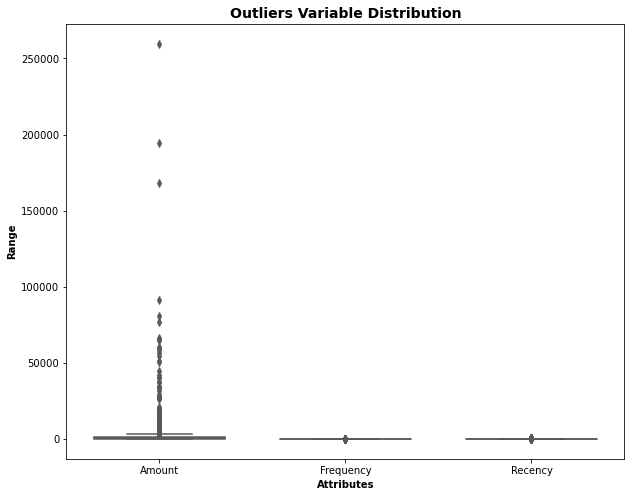

In [88]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [89]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [90]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3854, 3)

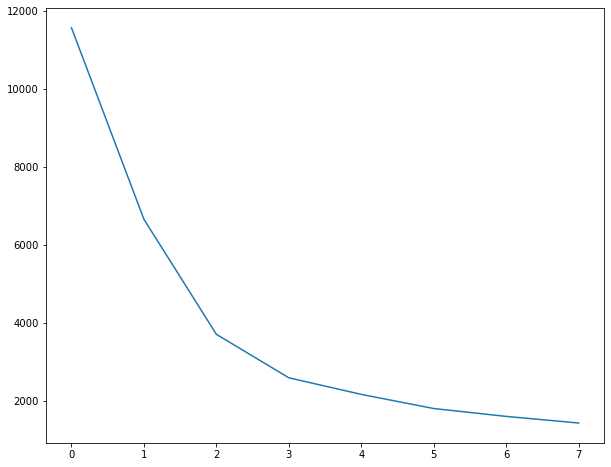

In [91]:
ssd = []
range_n_clusters = [1,2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)


In [92]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5542896138171406
For n_clusters=3, the silhouette score is 0.5124389071579789
For n_clusters=4, the silhouette score is 0.48650054452938163
For n_clusters=5, the silhouette score is 0.44966933335757964
For n_clusters=6, the silhouette score is 0.42426090299575264
For n_clusters=7, the silhouette score is 0.4037425384605855
For n_clusters=8, the silhouette score is 0.3917339153173792


In [93]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [94]:
kmeans.labels_

array([1, 2, 2, ..., 2, 1, 2])

In [95]:
rfm['Cluster_Id'] = (kmeans.labels_)+1
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
1,12747.0,4196.01,11,1,2
3,12749.0,4090.88,5,3,3
4,12820.0,942.34,4,2,3
5,12821.0,92.72,1,213,1
6,12822.0,948.88,2,70,3


In [96]:
rfm.groupby('Cluster_Id')['Cluster_Id'].count()

Cluster_Id
1     978
2     375
3    2501
Name: Cluster_Id, dtype: int64

<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

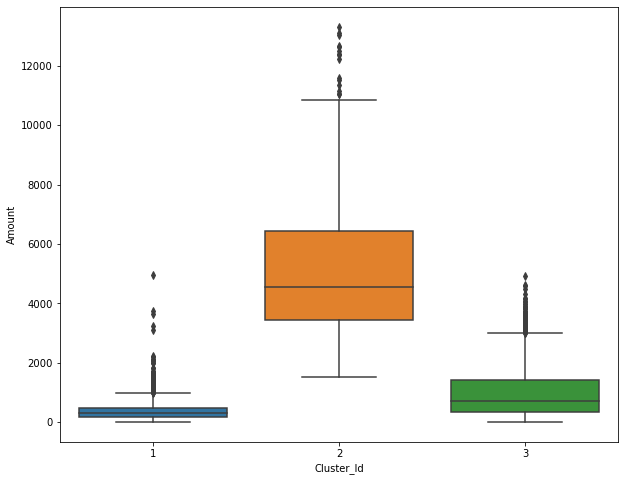

In [97]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

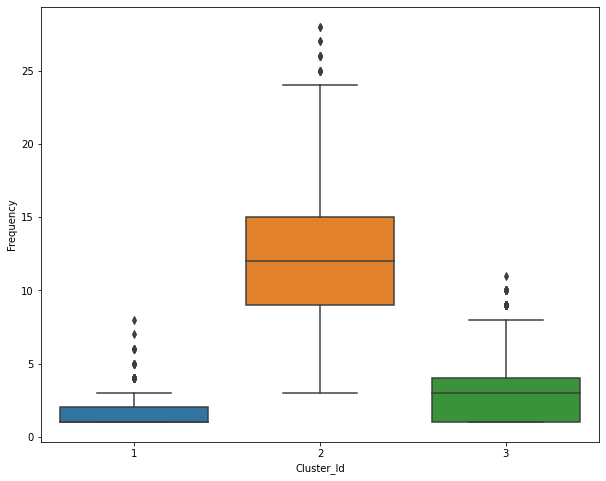

In [98]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

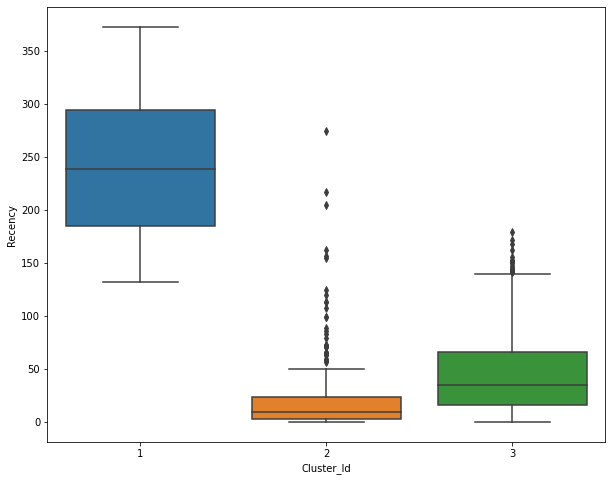

In [99]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)